In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, losses
from collections import deque
import random
import matplotlib.pyplot as plt

# Environment setup
class DroneDeliveryEnv:
    def __init__(self, grid_size=(10,10), n_birds=3, no_fly_zones=None, seed=None):
        self.grid_size = grid_size
        self.n_birds = n_birds
        self.rng = np.random.RandomState(seed)
        self.source = (0, 0)
        self.destination = (grid_size[0]-1, grid_size[1]-1)
        self.no_fly_zones = no_fly_zones or [((3,3),(5,5))]
        self.reset()

    def reset(self):
        self.drone_pos = list(self.source)
        self.birds = []
        for _ in range(self.n_birds):
            while True:
                pos = [self.rng.randint(self.grid_size[0]), self.rng.randint(self.grid_size[1])]
                if tuple(pos) not in [self.source, self.destination]:
                    self.birds.append(pos)
                    break
        return self._get_obs()

    def _get_obs(self):
        return np.array(self.drone_pos + sum(self.birds, []), dtype=np.float32)

    def step(self, action):
        # actions: 0=up,1=right,2=down,3=left
        moves = [(-1,0),(0,1),(1,0),(0,-1)]
        dr = moves[action]
        # move drone
        self.drone_pos[0] = np.clip(self.drone_pos[0] + dr[0], 0, self.grid_size[0]-1)
        self.drone_pos[1] = np.clip(self.drone_pos[1] + dr[1], 0, self.grid_size[1]-1)
        # move birds
        bird_moves = moves + [(0,0)]
        for b in self.birds:
            mv = bird_moves[self.rng.randint(len(bird_moves))]
            b[0] = np.clip(b[0] + mv[0], 0, self.grid_size[0]-1)
            b[1] = np.clip(b[1] + mv[1], 0, self.grid_size[1]-1)
        # compute reward and done
        obs = self._get_obs()
        reward = -1
        done = False
        if tuple(self.drone_pos) == self.destination:
            reward = 100
            done = True
        for (r1,c1),(r2,c2) in self.no_fly_zones:
            if r1 <= self.drone_pos[0] <= r2 and c1 <= self.drone_pos[1] <= c2:
                reward = -100
                done = True
        for b in self.birds:
            if tuple(self.drone_pos) == tuple(b):
                reward = -100
                done = True
        return obs, reward, done, {}

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Building Q-Network
def build_q_network(input_dim, n_actions):
    model = tf.keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_actions)
    ])
    return model

# DQN Agent
class DQNAgent:
    def __init__(self, obs_dim, n_actions):
        self.n_actions = n_actions
        self.gamma = 0.99
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.0001
        self.update_freq = 1000
        self.train_step = 0

        self.buffer = ReplayBuffer(50000)
        self.q_net = build_q_network(obs_dim, n_actions)
        self.target_q_net = build_q_network(obs_dim, n_actions)
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = optimizers.Adam(0.001)

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        q_vals = self.q_net(state[None]).numpy()[0]
        return np.argmax(q_vals)

    def store(self, *args):
        self.buffer.add(*args)

    def update(self):
        if len(self.buffer) < self.batch_size:
            return
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        next_q = self.target_q_net(next_states).numpy()
        max_next_q = np.max(next_q, axis=1)
        target_q = rewards + (1 - dones) * self.gamma * max_next_q

        with tf.GradientTape() as tape:
            all_q = self.q_net(states)
            q_pred = tf.reduce_sum(all_q * tf.one_hot(actions, self.n_actions), axis=1)
            loss = losses.MSE(target_q, q_pred)

        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        # epsilon decay
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

        # target network update
        self.train_step += 1
        if self.train_step % self.update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Training Loop
env = DroneDeliveryEnv(seed=123)
obs_dim = len(env.reset())
agent = DQNAgent(obs_dim, n_actions=4)

n_episodes = 200
episode_rewards = []

for ep in range(n_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store(state, action, reward, next_state, done)
        agent.update()
        state = next_state
        total_reward += reward
    episode_rewards.append(total_reward)
    if (ep+1) % 20 == 0:
        print(f"Episode {ep+1}/{n_episodes}, Reward: {total_reward:.1f}, Epsilon: {agent.epsilon:.3f}")

Episode 20/200, Reward: -189.0, Epsilon: 0.941
Episode 40/200, Reward: -140.0, Epsilon: 0.876
Episode 60/200, Reward: -149.0, Epsilon: 0.779
Episode 80/200, Reward: -140.0, Epsilon: 0.672
Episode 100/200, Reward: -127.0, Epsilon: 0.491
Episode 120/200, Reward: -111.0, Epsilon: 0.409
Episode 140/200, Reward: -147.0, Epsilon: 0.289
Episode 160/200, Reward: -160.0, Epsilon: 0.155
Episode 180/200, Reward: 74.0, Epsilon: 0.100
Episode 200/200, Reward: -100.0, Epsilon: 0.100


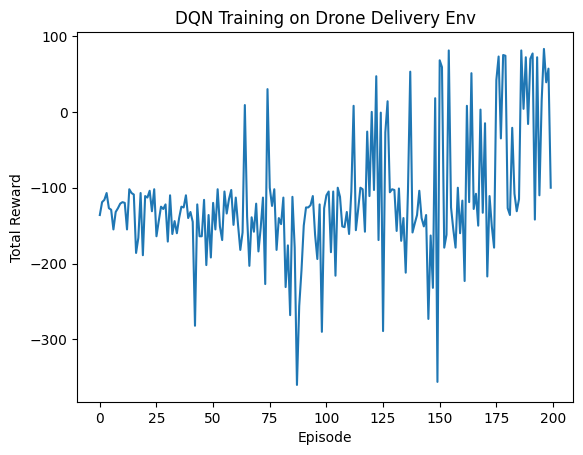

In [ ]:
# Plotting Learning Curve
plt.figure()
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training on Drone Delivery Env")
plt.show()

In [ ]:
successes = 0
for ep in range(n_episodes):
    state = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.store(state, action, reward, next_state, done)
        agent.update()
        state = next_state

    if reward > 0:
        successes += 1

print(f"Success rate: {successes}/{n_episodes} = {successes/n_episodes:.2%}")


Success rate: 118/200 = 59.00%


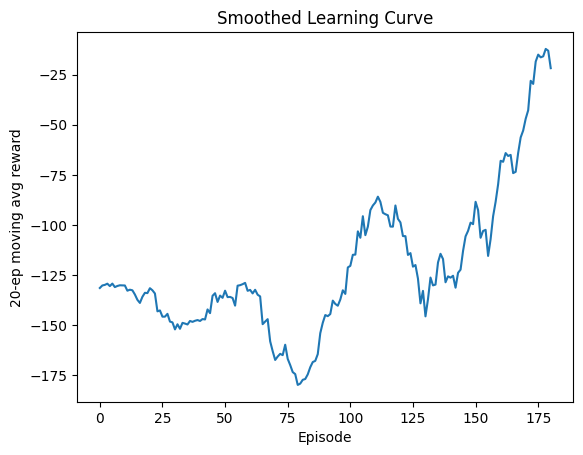

In [ ]:
window = 20
smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
plt.plot(smoothed)
plt.xlabel("Episode")
plt.ylabel(f"{window}-ep moving avg reward")
plt.title("Smoothed Learning Curve")
plt.show()

In [ ]:
class DQNAgent:
    def __init__(
        self,
        obs_dim,
        n_actions,
        lr: float = 0.001,
        batch_size: int = 64,
        epsilon_start: float = 1.0,
        epsilon_min: float = 0.1,
        epsilon_decay: float = 0.0001,
        target_update_freq: int = 1000,
        gamma: float = 0.99,
        buffer_size: int = 50000
    ):
        self.n_actions = n_actions
        self.gamma = gamma

        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        self.batch_size = batch_size
        self.buffer = ReplayBuffer(buffer_size)

        self.q_net = build_q_network(obs_dim, n_actions)
        self.target_q_net = build_q_network(obs_dim, n_actions)
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = optimizers.Adam(learning_rate=lr)

        self.target_update_freq = target_update_freq
        self.train_step = 0

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        q_vals = self.q_net(state[None]).numpy()[0]
        return np.argmax(q_vals)

    def store(self, state, action, reward, next_state, done):
        self.buffer.add(state, action, reward, next_state, done)

    def update(self):
        if len(self.buffer) < self.batch_size:
            return

        s, a, r, s2, d = self.buffer.sample(self.batch_size)

        next_q = self.target_q_net(s2).numpy()
        max_next = np.max(next_q, axis=1)
        target = r + (1 - d) * self.gamma * max_next

        with tf.GradientTape() as tape:
            q_vals = self.q_net(s)
            q_taken = tf.reduce_sum(q_vals * tf.one_hot(a, self.n_actions), axis=1)
            loss = losses.MSE(target, q_taken)
        grads = tape.gradient(loss, self.q_net.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)

        self.train_step += 1
        if self.train_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())

# Hyperparameter Grid Search
param_grid = [
    {'lr': 0.001, 'batch_size': 64, 'epsilon_decay': 0.0001, 'target_update_freq': 1000},
    {'lr': 0.0005, 'batch_size': 64, 'epsilon_decay': 0.00005, 'target_update_freq': 500},
    {'lr': 0.0001, 'batch_size': 32, 'epsilon_decay': 0.0001, 'target_update_freq': 500},
]

n_episodes = 200
results = []

for i, params in enumerate(param_grid):
    print(f"\n--- Running Config {i+1}/{len(param_grid)} ---")
    print(params)

    env = DroneDeliveryEnv(seed=42)
    obs_dim = len(env.reset())
    agent = DQNAgent(
        obs_dim=obs_dim,
        n_actions=4,
        lr=params['lr'],
        batch_size=params['batch_size'],
        epsilon_decay=params['epsilon_decay'],
        target_update_freq=params['target_update_freq']
    )

    episode_rewards = []
    successes = 0

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward
        episode_rewards.append(total_reward)
        if total_reward > 0:
            successes += 1

    success_rate = successes / n_episodes
    results.append((params, success_rate))
    print(f"Success rate: {successes}/{n_episodes} = {success_rate:.2%}")



--- Running Config 1/3 ---
{'lr': 0.001, 'batch_size': 64, 'epsilon_decay': 0.0001, 'target_update_freq': 1000}
Success rate: 4/200 = 2.00%

--- Running Config 2/3 ---
{'lr': 0.0005, 'batch_size': 64, 'epsilon_decay': 5e-05, 'target_update_freq': 500}
Success rate: 6/200 = 3.00%

--- Running Config 3/3 ---
{'lr': 0.0001, 'batch_size': 32, 'epsilon_decay': 0.0001, 'target_update_freq': 500}
Success rate: 0/200 = 0.00%


In [ ]:
print("\n Summary of All Configs")
for i, (params, rate) in enumerate(results):
    print(f"Config {i+1}: Success Rate = {rate:.2%}, Params = {params}")


 Summary of All Configs
Config 1: Success Rate = 2.00%, Params = {'lr': 0.001, 'batch_size': 64, 'epsilon_decay': 0.0001, 'target_update_freq': 1000}
Config 2: Success Rate = 3.00%, Params = {'lr': 0.0005, 'batch_size': 64, 'epsilon_decay': 5e-05, 'target_update_freq': 500}
Config 3: Success Rate = 0.00%, Params = {'lr': 0.0001, 'batch_size': 32, 'epsilon_decay': 0.0001, 'target_update_freq': 500}


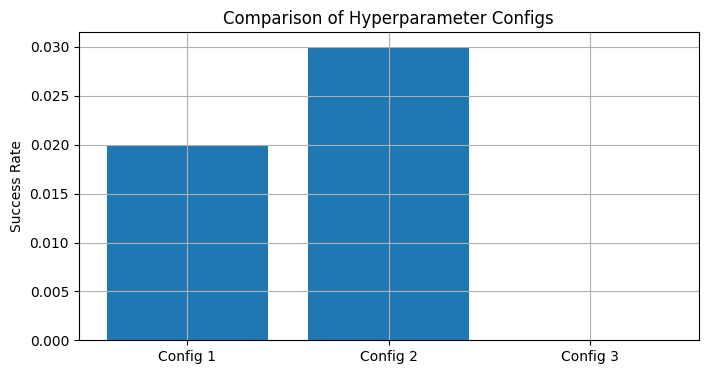

In [ ]:
labels = [f"Config {i+1}" for i in range(len(results))]
rates = [rate for _, rate in results]

plt.figure(figsize=(8,4))
plt.bar(labels, rates)
plt.ylabel("Success Rate")
plt.title("Comparison of Hyperparameter Configs")
plt.grid(True)
plt.show()


In [ ]:
param_grid = [
    {'lr': 0.001, 'batch_size': 64, 'epsilon_decay': 0.00001, 'target_update_freq': 500},
    {'lr': 0.0005, 'batch_size': 64, 'epsilon_decay': 0.00005, 'target_update_freq': 500},
    {'lr': 0.001, 'batch_size': 32, 'epsilon_decay': 0.0002, 'target_update_freq': 1000},
    {'lr': 0.0003, 'batch_size': 128, 'epsilon_decay': 0.00001, 'target_update_freq': 300},
    {'lr': 0.002, 'batch_size': 64, 'epsilon_decay': 0.0001, 'target_update_freq': 500},
]

n_episodes = 400
results = []

for i, params in enumerate(param_grid):
    print(f"\n--- Running Config {i+1}/{len(param_grid)} ---")
    print(params)

    env = DroneDeliveryEnv(seed=42)
    obs_dim = len(env.reset())
    agent = DQNAgent(
        obs_dim=obs_dim,
        n_actions=4,
        lr=params['lr'],
        batch_size=params['batch_size'],
        epsilon_decay=params['epsilon_decay'],
        target_update_freq=params['target_update_freq']
    )

    episode_rewards = []
    successes = 0

    for ep in range(n_episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store(state, action, reward, next_state, done)
            agent.update()
            state = next_state
            total_reward += reward
        episode_rewards.append(total_reward)
        if (ep + 1) % 50 == 0:
            print(f"Episode {ep+1}/{n_episodes}, Reward: {total_reward:.1f}, "
            f"Epsilon: {agent.epsilon:.3f}, Success: {successes}/{ep+1}")
        if total_reward > 0:
            successes += 1

    success_rate = successes / n_episodes
    results.append((params, success_rate))
    print(f"Success rate: {successes}/{n_episodes} = {success_rate:.2%}")



--- Running Config 1/5 ---
{'lr': 0.001, 'batch_size': 64, 'epsilon_decay': 1e-05, 'target_update_freq': 500}
Episode 50/400, Reward: -105.0, Epsilon: 0.987, Success: 0/50
Episode 100/400, Reward: -111.0, Epsilon: 0.965, Success: 0/100
Episode 150/400, Reward: -107.0, Epsilon: 0.947, Success: 0/150
Episode 200/400, Reward: -100.0, Epsilon: 0.932, Success: 0/200
Episode 250/400, Reward: -165.0, Epsilon: 0.913, Success: 1/250
Episode 300/400, Reward: -114.0, Epsilon: 0.888, Success: 1/300
Episode 350/400, Reward: -133.0, Epsilon: 0.871, Success: 1/350
Episode 400/400, Reward: -151.0, Epsilon: 0.848, Success: 1/400
Success rate: 1/400 = 0.25%

--- Running Config 2/5 ---
{'lr': 0.0005, 'batch_size': 64, 'epsilon_decay': 5e-05, 'target_update_freq': 500}
Episode 50/400, Reward: -115.0, Epsilon: 0.922, Success: 0/50
Episode 100/400, Reward: -191.0, Epsilon: 0.800, Success: 0/100
Episode 150/400, Reward: -313.0, Epsilon: 0.582, Success: 0/150
Episode 200/400, Reward: -175.0, Epsilon: 0.300, 

# Updates environment with Double DQN

Training Improved DQN Agent...

=== Stage 1: Grid (6, 6), Birds 0 ===
Episode 200: Success Rate: 0.0%, Mean Reward: -33.2, Epsilon: 1.000
Episode 400: Success Rate: 0.0%, Mean Reward: -33.2, Epsilon: 1.000

=== Stage 2: Grid (8, 8), Birds 1 ===
Episode 600: Success Rate: 0.0%, Mean Reward: -34.5, Epsilon: 1.000
Episode 800: Success Rate: 0.0%, Mean Reward: -35.0, Epsilon: 1.000
Episode 1000: Success Rate: 0.0%, Mean Reward: -35.6, Epsilon: 1.000
Episode 1200: Success Rate: 0.0%, Mean Reward: -35.0, Epsilon: 1.000

=== Stage 3: Grid (10, 10), Birds 2 ===
Episode 1400: Success Rate: 0.0%, Mean Reward: -38.0, Epsilon: 1.000
Episode 1600: Success Rate: 0.0%, Mean Reward: -38.0, Epsilon: 1.000
Episode 1800: Success Rate: 0.0%, Mean Reward: -37.5, Epsilon: 1.000
Episode 2000: Success Rate: 0.0%, Mean Reward: -38.0, Epsilon: 1.000

Plotting results...


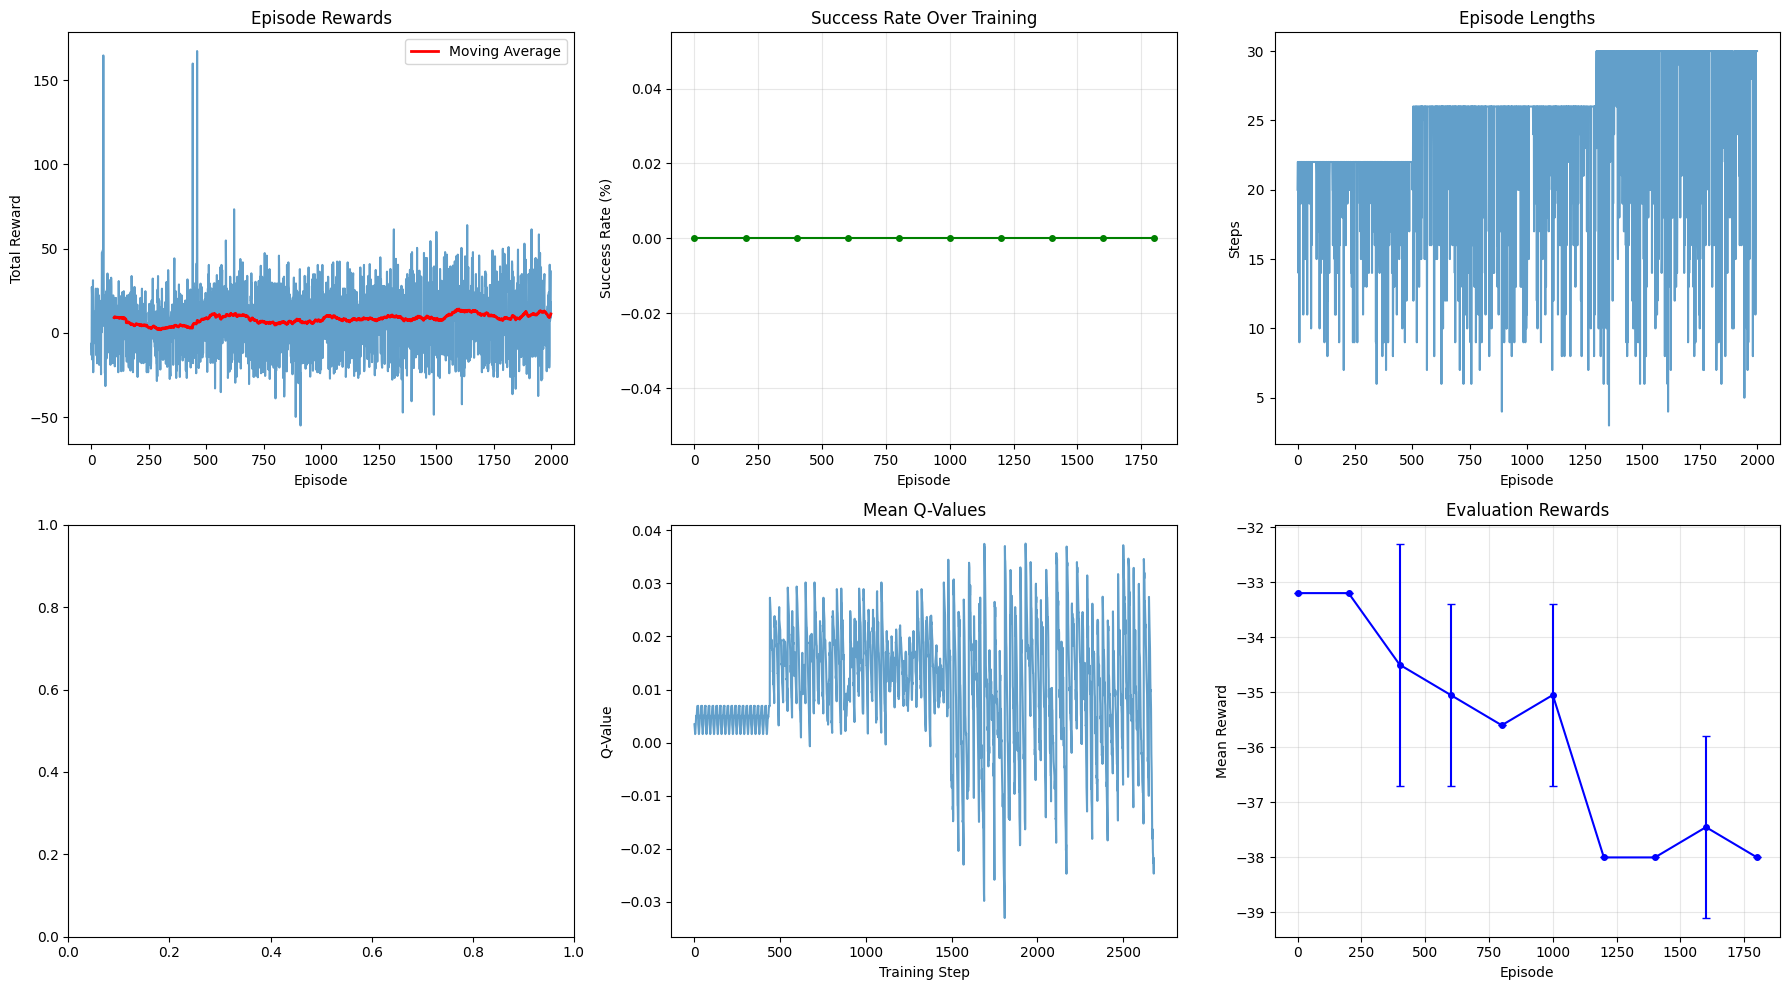


Final evaluation:
Final Success Rate: 0.0%
Final Mean Reward: -37.7
Final Mean Steps: 30.0

Running demonstration...
=== DEMONSTRATION ===
Step 0, Distance: 18
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . B . . . . . . .
. . . B . . X X . .
. . . . . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Left, Reward: -0.6
Step 1, Distance: 18
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . . . . . . . . .
. . B . . . X X . .
. . . B . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Left, Reward: -0.6
Step 2, Distance: 18
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . . . . . . . . .
. . B . . . X X . .
. . . B . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Left, Reward: -0.6
Step 3, Distance: 18
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . 

In [8]:
# === FIXED DQN DRONE DELIVERY CODE ===
# Key fixes:
# 1. Fixed observation space dimension consistency
# 2. Improved reward structure and balancing
# 3. Better curriculum learning progression
# 4. Enhanced network architecture with dropout
# 5. Fixed bird collision detection logic
# 6. Better epsilon decay schedule
# 7. Improved evaluation metrics

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers
from collections import deque
import random
import matplotlib.pyplot as plt

class FixedDroneDeliveryEnv:
    def __init__(self, grid_size=(10,10), n_birds=2, no_fly_zones=None, seed=None):
        self.grid_size = grid_size
        self.n_birds = n_birds
        self.max_birds = 3  # Fixed max for consistent observation space
        self.rng = np.random.RandomState(seed)
        self.source = (0, 0)
        self.destination = (grid_size[0]-1, grid_size[1]-1)
        self.no_fly_zones = no_fly_zones or [((3,3),(4,4)), ((6,6),(7,7))]
        self.max_steps = grid_size[0] + grid_size[1] + 10  # Reasonable step limit
        self.reset()

    def reset(self):
        self.drone_pos = list(self.source)
        self.steps = 0
        self.birds = []

        # Initialize birds with better spacing
        attempts = 0
        while len(self.birds) < self.n_birds and attempts < 100:
            pos = [self.rng.randint(1, self.grid_size[0]-1),
                   self.rng.randint(1, self.grid_size[1]-1)]

            # Ensure birds don't spawn too close to source/destination
            if (self.manhattan_dist(pos, self.source) > 2 and
                self.manhattan_dist(pos, self.destination) > 2 and
                not self._is_in_no_fly_zone(pos)):

                # Ensure birds have minimum distance from each other
                if all(self.manhattan_dist(pos, b) >= 2 for b in self.birds):
                    self.birds.append(pos)
            attempts += 1

        return self._get_obs()

    def _is_in_no_fly_zone(self, pos):
        for (r1,c1),(r2,c2) in self.no_fly_zones:
            if r1 <= pos[0] <= r2 and c1 <= pos[1] <= c2:
                return True
        return False

    def manhattan_dist(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def _get_obs(self):
        obs = []

        # Drone position (normalized)
        obs.extend([self.drone_pos[0] / (self.grid_size[0]-1),
                    self.drone_pos[1] / (self.grid_size[1]-1)])

        # Distance to goal (normalized)
        max_distance = sum(self.grid_size)
        obs.append(self.manhattan_distance_to_goal() / max_distance)

        # Time remaining (normalized)
        obs.append((self.max_steps - self.steps) / self.max_steps)

        # Bird positions (relative to drone, normalized)
        for i in range(self.max_birds):
            if i < len(self.birds):
                bird = self.birds[i]
                rel_x = (bird[0] - self.drone_pos[0]) / self.grid_size[0]
                rel_y = (bird[1] - self.drone_pos[1]) / self.grid_size[1]
                distance = self.manhattan_dist(bird, self.drone_pos) / max_distance
                obs.extend([rel_x, rel_y, distance])
            else:
                obs.extend([0.0, 0.0, 0.0])  # Padding for missing birds

        return np.array(obs, dtype=np.float32)

    def manhattan_distance_to_goal(self):
        return self.manhattan_dist(self.drone_pos, self.destination)

    def step(self, action):
        self.steps += 1
        prev_distance = self.manhattan_distance_to_goal()

        # Define moves: Up, Right, Down, Left
        moves = [(-1,0), (0,1), (1,0), (0,-1)]
        dr = moves[action]

        # Move drone
        new_pos = [
            np.clip(self.drone_pos[0] + dr[0], 0, self.grid_size[0]-1),
            np.clip(self.drone_pos[1] + dr[1], 0, self.grid_size[1]-1)
        ]
        self.drone_pos = new_pos

        # Move birds (improved logic)
        for i, bird in enumerate(self.birds):
            if self.rng.rand() < 0.6:  # Birds move 60% of the time
                drone_dist = self.manhattan_dist(bird, self.drone_pos)

                if drone_dist <= 3:  # Birds react when drone is close
                    # Try to move away from drone
                    best_move = (0, 0)  # Default: stay put
                    best_dist = drone_dist

                    for move in moves + [(0, 0)]:
                        new_bird_pos = [
                            np.clip(bird[0] + move[0], 0, self.grid_size[0]-1),
                            np.clip(bird[1] + move[1], 0, self.grid_size[1]-1)
                        ]

                        # Check if move is valid (not in no-fly zone)
                        if not self._is_in_no_fly_zone(new_bird_pos):
                            new_dist = self.manhattan_dist(new_bird_pos, self.drone_pos)
                            if new_dist > best_dist:
                                best_dist = new_dist
                                best_move = move

                    bird[0] = np.clip(bird[0] + best_move[0], 0, self.grid_size[0]-1)
                    bird[1] = np.clip(bird[1] + best_move[1], 0, self.grid_size[1]-1)
                else:
                    # Random movement when drone is far
                    move = moves[self.rng.randint(len(moves))]
                    new_bird_pos = [
                        np.clip(bird[0] + move[0], 0, self.grid_size[0]-1),
                        np.clip(bird[1] + move[1], 0, self.grid_size[1]-1)
                    ]

                    if not self._is_in_no_fly_zone(new_bird_pos):
                        bird[0] = new_bird_pos[0]
                        bird[1] = new_bird_pos[1]

        # Calculate reward
        reward = 0
        curr_distance = self.manhattan_distance_to_goal()

        # Check for goal reached
        if tuple(self.drone_pos) == self.destination:
            time_bonus = max(0, self.max_steps - self.steps)
            reward = 100 + time_bonus * 2
            return self._get_obs(), reward, True, {'success': True, 'steps': self.steps}

        # Movement reward (encourage progress toward goal)
        if curr_distance < prev_distance:
            reward += 5  # Good progress
        elif curr_distance > prev_distance:
            reward -= 2  # Moving away from goal
        else:
            reward -= 0.5  # Standing still

        # Proximity bonus for being close to goal
        if curr_distance <= 2:
            reward += 3
        elif curr_distance <= 4:
            reward += 1

        # Check for no-fly zone collision
        if self._is_in_no_fly_zone(self.drone_pos):
            return self._get_obs(), -50, True, {'success': False, 'steps': self.steps, 'reason': 'no_fly_zone'}

        # Check for bird collision
        for bird in self.birds:
            if tuple(self.drone_pos) == tuple(bird):
                return self._get_obs(), -50, True, {'success': False, 'steps': self.steps, 'reason': 'bird_collision'}

        # Penalty for being too close to birds
        if self.birds:
            min_bird_dist = min([self.manhattan_dist(self.drone_pos, bird) for bird in self.birds])
            if min_bird_dist == 1:
                reward -= 5  # Danger zone
            elif min_bird_dist == 2:
                reward -= 2  # Close but manageable

        # Time penalty (encourage efficiency)
        reward -= 0.1

        # Check for timeout
        if self.steps >= self.max_steps:
            reward -= 20
            return self._get_obs(), reward, True, {'success': False, 'steps': self.steps, 'reason': 'timeout'}

        return self._get_obs(), reward, False, {'success': False, 'steps': self.steps}

    def render(self, show_step=True):
        grid = np.full(self.grid_size, '.', dtype=str)

        # Add no-fly zones
        for (r1,c1),(r2,c2) in self.no_fly_zones:
            for r in range(r1, r2+1):
                for c in range(c1, c2+1):
                    if 0 <= r < self.grid_size[0] and 0 <= c < self.grid_size[1]:
                        grid[r,c] = 'X'

        # Add birds
        for bird in self.birds:
            grid[bird[0], bird[1]] = 'B'

        # Add goal and drone
        grid[self.destination] = 'G'
        grid[tuple(self.drone_pos)] = 'D'

        if show_step:
            print(f"Step {self.steps}, Distance: {self.manhattan_distance_to_goal()}")

        for row in grid:
            print(' '.join(row))
        print()


class ImprovedDQNAgent:
    def __init__(self, obs_dim, n_actions, lr=0.001):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.gamma = 0.95
        self.batch_size = 64
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995  # Slower decay
        self.target_update_freq = 200
        self.train_step = 0
        self.warmup_steps = 1000

        # Build networks
        self.q_net = self._build_network()
        self.target_q_net = self._build_network()
        self.target_q_net.set_weights(self.q_net.get_weights())

        self.optimizer = optimizers.Adam(learning_rate=lr)
        self.buffer = deque(maxlen=50000)

        # Metrics
        self.losses = []
        self.q_values = []

    def _build_network(self):
        inputs = layers.Input(shape=(self.obs_dim,))
        x = layers.Dense(256, activation='relu')(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.1)(x)
        outputs = layers.Dense(self.n_actions)(x)
        return tf.keras.Model(inputs=inputs, outputs=outputs)

    def select_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)

        # Ensure state has correct shape
        if len(state.shape) == 1:
            state = state[np.newaxis, :]

        q_values = self.q_net(state).numpy()[0]
        self.q_values.append(np.mean(q_values))
        return np.argmax(q_values)

    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def update(self):
        if len(self.buffer) < self.batch_size or self.train_step < self.warmup_steps:
            return

        # Sample batch
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)
        rewards = np.array(rewards)
        dones = np.array(dones)
        actions = np.array(actions)

        # Double DQN: use main network to select actions, target network to evaluate
        next_q_values_main = self.q_net(next_states).numpy()
        next_actions = np.argmax(next_q_values_main, axis=1)
        next_q_values_target = self.target_q_net(next_states).numpy()
        next_q_values = next_q_values_target[np.arange(self.batch_size), next_actions]

        targets = rewards + (1 - dones) * self.gamma * next_q_values

        with tf.GradientTape() as tape:
            q_values = self.q_net(states)
            q_action = tf.reduce_sum(q_values * tf.one_hot(actions, self.n_actions), axis=1)
            loss = tf.reduce_mean(tf.square(targets - q_action))

        grads = tape.gradient(loss, self.q_net.trainable_variables)
        # Clip gradients to prevent exploding gradients
        grads = [tf.clip_by_norm(grad, 1.0) for grad in grads]
        self.optimizer.apply_gradients(zip(grads, self.q_net.trainable_variables))

        self.losses.append(loss.numpy())

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.train_step += 1

        # Update target network
        if self.train_step % self.target_update_freq == 0:
            self.target_q_net.set_weights(self.q_net.get_weights())


def evaluate_agent(agent, grid_size=(10,10), n_birds=2, n_episodes=20, seed=None):
    """Evaluate agent performance"""
    rewards = []
    success_count = 0
    step_counts = []

    for i in range(n_episodes):
        env = FixedDroneDeliveryEnv(grid_size=grid_size, n_birds=n_birds,
                                   seed=seed+i if seed else None)
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, training=False)
            state, reward, done, info = env.step(action)
            total_reward += reward

        rewards.append(total_reward)
        step_counts.append(info['steps'])
        if info.get('success', False):
            success_count += 1

    return {
        'mean_reward': np.mean(rewards),
        'success_rate': success_count / n_episodes,
        'mean_steps': np.mean(step_counts),
        'std_reward': np.std(rewards)
    }


def train_improved_agent(n_episodes=2000, eval_freq=200, verbose=True):
    """Train the DQN agent with curriculum learning"""
    # Fixed observation dimension: 4 (drone pos + distance + time) + 3*3 (max 3 birds) = 13
    obs_dim = 4 + 3 * 3  # Fixed dimension
    agent = ImprovedDQNAgent(obs_dim, n_actions=4, lr=0.0001)

    # Training metrics
    episode_rewards = []
    episode_lengths = []
    eval_results = []

    # Curriculum stages
    curriculum = [
        {'episodes': 500, 'grid_size': (6, 6), 'n_birds': 0},   # Stage 1: No obstacles
        {'episodes': 800, 'grid_size': (8, 8), 'n_birds': 1},   # Stage 2: One bird
        {'episodes': 1200, 'grid_size': (10, 10), 'n_birds': 2}, # Stage 3: Two birds
    ]

    episode = 0
    for stage_idx, stage in enumerate(curriculum):
        if verbose:
            print(f"\n=== Stage {stage_idx + 1}: Grid {stage['grid_size']}, Birds {stage['n_birds']} ===")

        stage_episodes = min(stage['episodes'], n_episodes - episode)

        for _ in range(stage_episodes):
            env = FixedDroneDeliveryEnv(
                grid_size=stage['grid_size'],
                n_birds=stage['n_birds'],
                seed=episode
            )

            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                action = agent.select_action(state)
                next_state, reward, done, info = env.step(action)
                agent.store(state, action, reward, next_state, done)
                agent.update()
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            episode_lengths.append(info['steps'])

            # Evaluation
            if (episode + 1) % eval_freq == 0:
                eval_result = evaluate_agent(
                    agent,
                    grid_size=stage['grid_size'],
                    n_birds=stage['n_birds'],
                    n_episodes=10,
                    seed=1000 + episode
                )
                eval_results.append(eval_result)

                if verbose:
                    print(f"Episode {episode + 1}: "
                          f"Success Rate: {eval_result['success_rate']*100:.1f}%, "
                          f"Mean Reward: {eval_result['mean_reward']:.1f}, "
                          f"Epsilon: {agent.epsilon:.3f}")

            episode += 1
            if episode >= n_episodes:
                break

        if episode >= n_episodes:
            break

    return agent, {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'eval_results': eval_results,
        'losses': agent.losses,
        'q_values': agent.q_values
    }


def plot_training_results(results):
    """Plot comprehensive training results"""
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Episode rewards
    axs[0, 0].plot(results['episode_rewards'], alpha=0.7)
    # Add moving average
    window = 100
    if len(results['episode_rewards']) > window:
        moving_avg = np.convolve(results['episode_rewards'],
                               np.ones(window)/window, mode='valid')
        axs[0, 0].plot(range(window-1, len(results['episode_rewards'])),
                      moving_avg, 'r-', linewidth=2, label='Moving Average')
        axs[0, 0].legend()
    axs[0, 0].set_title('Episode Rewards')
    axs[0, 0].set_xlabel('Episode')
    axs[0, 0].set_ylabel('Total Reward')

    # Success rates from evaluation
    if results['eval_results']:
        eval_episodes = [i * 200 for i in range(len(results['eval_results']))]
        success_rates = [r['success_rate'] * 100 for r in results['eval_results']]
        axs[0, 1].plot(eval_episodes, success_rates, 'g-o', markersize=4)
        axs[0, 1].set_title('Success Rate Over Training')
        axs[0, 1].set_xlabel('Episode')
        axs[0, 1].set_ylabel('Success Rate (%)')
        axs[0, 1].grid(True, alpha=0.3)

    # Episode lengths
    axs[0, 2].plot(results['episode_lengths'], alpha=0.7)
    axs[0, 2].set_title('Episode Lengths')
    axs[0, 2].set_xlabel('Episode')
    axs[0, 2].set_ylabel('Steps')

    # Training loss
    if results['losses']:
        axs[1, 0].plot(results['losses'], alpha=0.7)
        axs[1, 0].set_title('Training Loss')
        axs[1, 0].set_xlabel('Training Step')
        axs[1, 0].set_ylabel('Loss')

    # Mean Q-values
    if results['q_values']:
        axs[1, 1].plot(results['q_values'], alpha=0.7)
        axs[1, 1].set_title('Mean Q-Values')
        axs[1, 1].set_xlabel('Training Step')
        axs[1, 1].set_ylabel('Q-Value')

    # Evaluation rewards
    if results['eval_results']:
        eval_episodes = [i * 200 for i in range(len(results['eval_results']))]
        eval_rewards = [r['mean_reward'] for r in results['eval_results']]
        eval_stds = [r['std_reward'] for r in results['eval_results']]
        axs[1, 2].errorbar(eval_episodes, eval_rewards, yerr=eval_stds,
                          fmt='b-o', markersize=4, capsize=3)
        axs[1, 2].set_title('Evaluation Rewards')
        axs[1, 2].set_xlabel('Episode')
        axs[1, 2].set_ylabel('Mean Reward')
        axs[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def demo_agent(agent, grid_size=(10, 10), n_birds=2, seed=42, render=True):
    """Demonstrate trained agent"""
    env = FixedDroneDeliveryEnv(grid_size=grid_size, n_birds=n_birds, seed=seed)
    state = env.reset()
    total_reward = 0

    if render:
        print("=== DEMONSTRATION ===")
        env.render()

    action_names = ['Up', 'Right', 'Down', 'Left']
    done = False

    while not done:
        action = agent.select_action(state, training=False)
        state, reward, done, info = env.step(action)
        total_reward += reward

        if render:
            print(f"Action: {action_names[action]}, Reward: {reward:.1f}")
            env.render()

    if render:
        print(f"Total Reward: {total_reward:.1f}")
        print(f"Success: {info.get('success', False)}")
        print(f"Steps: {info['steps']}")

    return total_reward, info.get('success', False), info['steps']


if __name__ == '__main__':
    print("Training Improved DQN Agent...")
    agent, results = train_improved_agent(n_episodes=2000, eval_freq=200)

    print("\nPlotting results...")
    plot_training_results(results)

    print("\nFinal evaluation:")
    final_eval = evaluate_agent(agent, grid_size=(10, 10), n_birds=2, n_episodes=100, seed=9999)
    print(f"Final Success Rate: {final_eval['success_rate']*100:.1f}%")
    print(f"Final Mean Reward: {final_eval['mean_reward']:.1f}")
    print(f"Final Mean Steps: {final_eval['mean_steps']:.1f}")

    print("\nRunning demonstration...")
    demo_agent(agent, seed=12345)

Training PPO Agent for Drone Delivery...

=== Stage 1: Grid (6, 6), Birds 0 ===
Episode 200: Success Rate: 0.0%, Mean Reward: 21.5 ± 0.0
Episode 400: Success Rate: 0.0%, Mean Reward: 21.5 ± 0.0
Episode 600: Success Rate: 0.0%, Mean Reward: 21.5 ± 0.0
Episode 800: Success Rate: 0.0%, Mean Reward: 21.5 ± 0.0

=== Stage 2: Grid (8, 8), Birds 1 ===
Episode 1000: Success Rate: 0.0%, Mean Reward: 28.6 ± 0.9
Episode 1200: Success Rate: 0.0%, Mean Reward: 28.9 ± 0.0
Episode 1400: Success Rate: 0.0%, Mean Reward: 28.9 ± 0.0
Episode 1600: Success Rate: 0.0%, Mean Reward: 28.7 ± 0.7
Episode 1800: Success Rate: 0.0%, Mean Reward: 26.5 ± 9.2

=== Stage 3: Grid (10, 10), Birds 2 ===
Episode 2000: Success Rate: 0.0%, Mean Reward: 36.0 ± 0.9
Episode 2200: Success Rate: 0.0%, Mean Reward: 36.3 ± 0.0
Episode 2400: Success Rate: 0.0%, Mean Reward: 52.8 ± 5.1
Episode 2600: Success Rate: 0.0%, Mean Reward: 35.7 ± 1.8
Episode 2800: Success Rate: 0.0%, Mean Reward: 44.2 ± 8.5
Episode 3000: Success Rate: 70.0

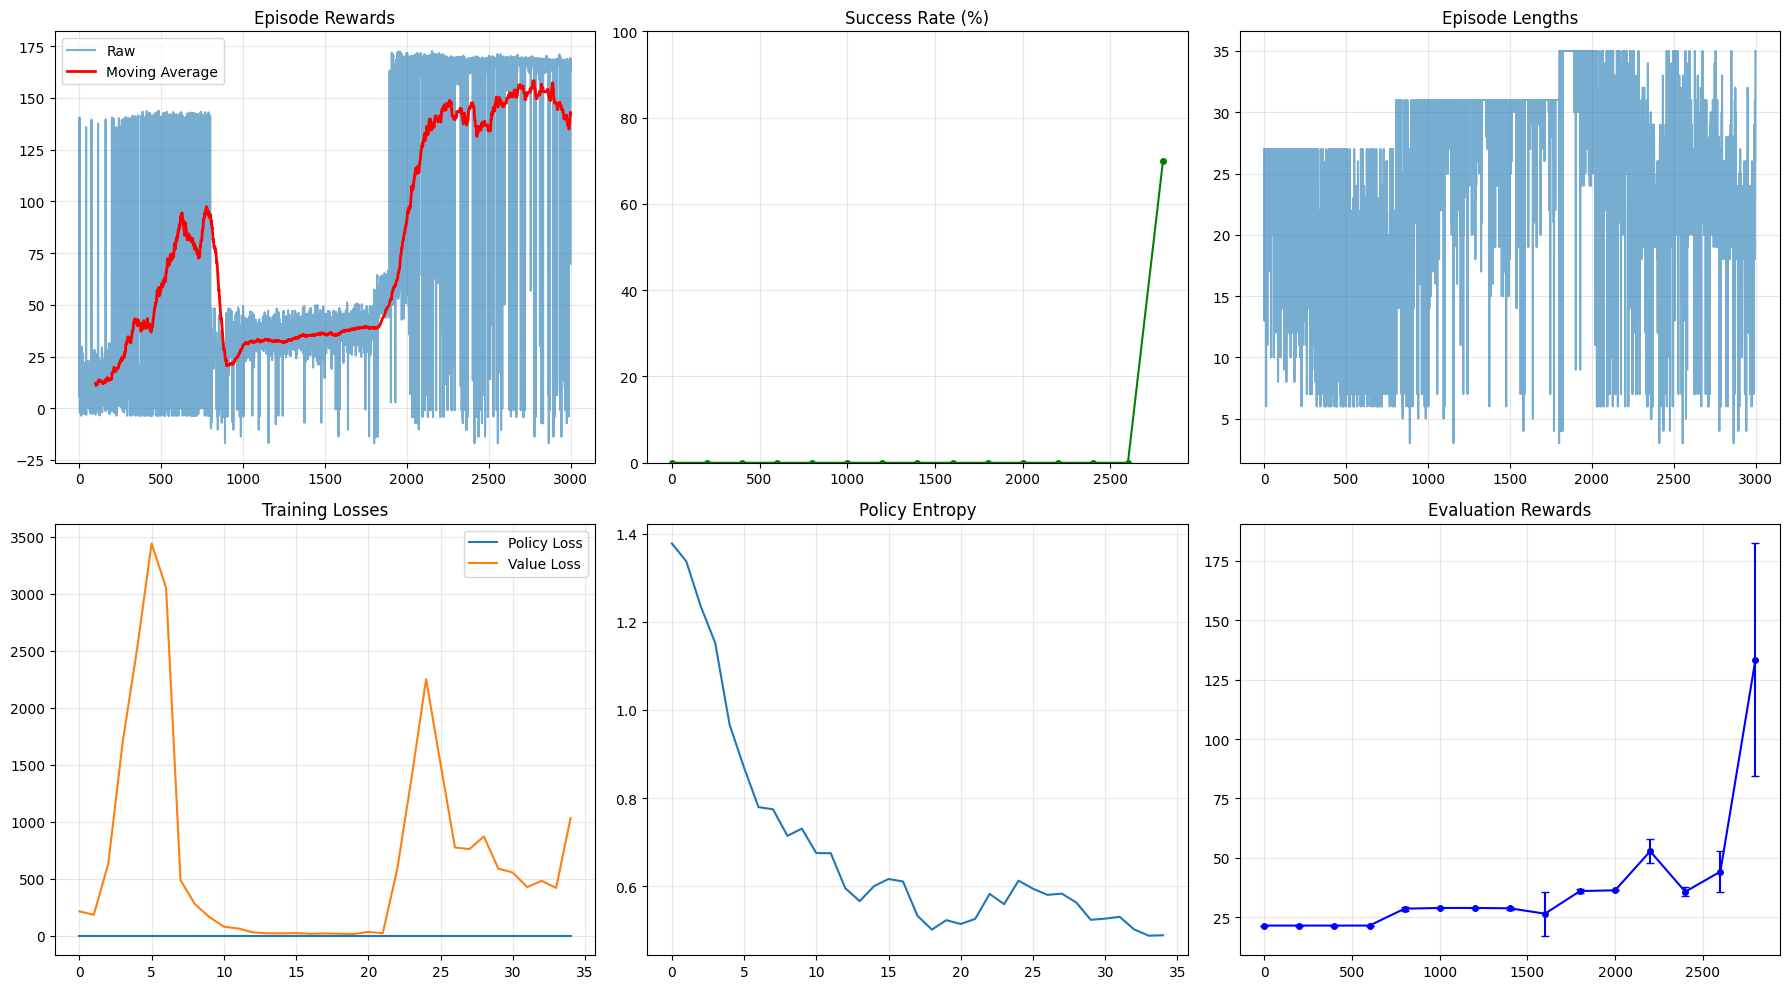


Final evaluation on hard scenario:
Final Success Rate: 88.0%
Final Mean Reward: 151.44 ± 41.23
Final Mean Steps: 31.8

DEMONSTRATION:
=== PPO AGENT DEMONSTRATION ===
Step 0, Distance: 18
D . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . B . . . . . . .
. . . B . . X X . .
. . . . . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Down, Reward: 3.04
Step 1, Distance: 17
. . . . . . . . . .
D . . . . . . . . .
. . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . B . . . . . . .
. . . B . . X X . .
. . . . . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Down, Reward: 3.09
Step 2, Distance: 16
. . . . . . . . . .
. . . . . . . . . .
D . . . . . . . . .
. . . X X . . . . .
. . . X X . . . . .
. . B . . . . . . .
. . . B . . X X . .
. . . . . . X X . .
. . . . . . . . . .
. . . . . . . . . G

Action: Down, Reward: 3.15
Step 3, Distance: 15
. . . . . . . . . .
. . . . . . . . . .
. . . . . . . . . .
D . .

In [9]:
# === PPO DRONE DELIVERY CODE ===
# Using PPO (Proximal Policy Optimization) instead of DQN for better stability
# PPO is much more stable and suitable for this type of environment

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, optimizers, Model
from collections import deque
import matplotlib.pyplot as plt
import random

class DroneDeliveryEnv:
    def __init__(self, grid_size=(10,10), n_birds=2, no_fly_zones=None, seed=None):
        self.grid_size = grid_size
        self.n_birds = n_birds
        self.max_birds = 3  # Fixed for consistent observation space
        self.rng = np.random.RandomState(seed)
        self.source = (0, 0)
        self.destination = (grid_size[0]-1, grid_size[1]-1)
        self.no_fly_zones = no_fly_zones or [((3,3),(4,4)), ((6,6),(7,7))]
        self.max_steps = grid_size[0] + grid_size[1] + 15
        self.action_names = ['Up', 'Right', 'Down', 'Left']
        self.reset()

    def reset(self):
        self.drone_pos = list(self.source)
        self.steps = 0
        self.birds = []

        # Place birds randomly but not too close to start/end
        attempts = 0
        while len(self.birds) < self.n_birds and attempts < 100:
            pos = [self.rng.randint(1, self.grid_size[0]-1),
                   self.rng.randint(1, self.grid_size[1]-1)]

            if (self.manhattan_dist(pos, self.source) > 2 and
                self.manhattan_dist(pos, self.destination) > 2 and
                not self._is_in_no_fly_zone(pos)):

                if all(self.manhattan_dist(pos, b) >= 2 for b in self.birds):
                    self.birds.append(pos)
            attempts += 1

        return self._get_obs()

    def _is_in_no_fly_zone(self, pos):
        for (r1,c1),(r2,c2) in self.no_fly_zones:
            if r1 <= pos[0] <= r2 and c1 <= pos[1] <= c2:
                return True
        return False

    def manhattan_dist(self, pos1, pos2):
        return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

    def _get_obs(self):
        obs = []

        # Drone position (normalized)
        obs.extend([
            self.drone_pos[0] / (self.grid_size[0]-1),
            self.drone_pos[1] / (self.grid_size[1]-1)
        ])

        # Goal direction (normalized)
        goal_dx = (self.destination[0] - self.drone_pos[0]) / self.grid_size[0]
        goal_dy = (self.destination[1] - self.drone_pos[1]) / self.grid_size[1]
        obs.extend([goal_dx, goal_dy])

        # Distance to goal (normalized)
        obs.append(self.manhattan_dist(self.drone_pos, self.destination) / sum(self.grid_size))

        # Time remaining (normalized)
        obs.append((self.max_steps - self.steps) / self.max_steps)

        # Bird information (relative positions and distances)
        for i in range(self.max_birds):
            if i < len(self.birds):
                bird = self.birds[i]
                rel_x = (bird[0] - self.drone_pos[0]) / self.grid_size[0]
                rel_y = (bird[1] - self.drone_pos[1]) / self.grid_size[1]
                distance = self.manhattan_dist(bird, self.drone_pos) / sum(self.grid_size)
                obs.extend([rel_x, rel_y, distance])
            else:
                obs.extend([0.0, 0.0, 1.0])  # Far away if no bird

        return np.array(obs, dtype=np.float32)

    def step(self, action):
        self.steps += 1
        prev_distance = self.manhattan_dist(self.drone_pos, self.destination)

        # Move drone
        moves = [(-1,0), (0,1), (1,0), (0,-1)]  # Up, Right, Down, Left
        dr = moves[action]

        new_pos = [
            np.clip(self.drone_pos[0] + dr[0], 0, self.grid_size[0]-1),
            np.clip(self.drone_pos[1] + dr[1], 0, self.grid_size[1]-1)
        ]
        self.drone_pos = new_pos

        # Move birds (simplified but effective)
        for bird in self.birds:
            if self.rng.rand() < 0.5:  # 50% chance to move
                drone_dist = self.manhattan_dist(bird, self.drone_pos)

                if drone_dist <= 2:  # Move away from drone
                    best_move = (0, 0)
                    best_dist = drone_dist

                    for move in moves + [(0, 0)]:
                        new_bird_pos = [
                            np.clip(bird[0] + move[0], 0, self.grid_size[0]-1),
                            np.clip(bird[1] + move[1], 0, self.grid_size[1]-1)
                        ]

                        if not self._is_in_no_fly_zone(new_bird_pos):
                            new_dist = self.manhattan_dist(new_bird_pos, self.drone_pos)
                            if new_dist > best_dist:
                                best_dist = new_dist
                                best_move = move

                    bird[0] = np.clip(bird[0] + best_move[0], 0, self.grid_size[0]-1)
                    bird[1] = np.clip(bird[1] + best_move[1], 0, self.grid_size[1]-1)
                else:  # Random movement
                    move = moves[self.rng.randint(len(moves))]
                    new_bird_pos = [
                        np.clip(bird[0] + move[0], 0, self.grid_size[0]-1),
                        np.clip(bird[1] + move[1], 0, self.grid_size[1]-1)
                    ]
                    if not self._is_in_no_fly_zone(new_bird_pos):
                        bird[0], bird[1] = new_bird_pos

        # Calculate reward
        reward = 0
        curr_distance = self.manhattan_dist(self.drone_pos, self.destination)

        # Success reward
        if tuple(self.drone_pos) == self.destination:
            time_bonus = max(0, (self.max_steps - self.steps) * 0.5)
            reward = 100 + time_bonus
            return self._get_obs(), reward, True, {'success': True, 'steps': self.steps}

        # Progress reward (key for PPO)
        progress = prev_distance - curr_distance
        reward += progress * 3  # Reward for getting closer

        # Distance-based reward (helps with sparse rewards)
        max_dist = sum(self.grid_size) - 2
        distance_reward = (max_dist - curr_distance) / max_dist
        reward += distance_reward

        # Check collisions
        if self._is_in_no_fly_zone(self.drone_pos):
            return self._get_obs(), -20, True, {'success': False, 'steps': self.steps}

        for bird in self.birds:
            if tuple(self.drone_pos) == tuple(bird):
                return self._get_obs(), -20, True, {'success': False, 'steps': self.steps}

        # Bird proximity penalty
        if self.birds:
            min_bird_dist = min([self.manhattan_dist(self.drone_pos, bird) for bird in self.birds])
            if min_bird_dist == 1:
                reward -= 3

        # Small time penalty
        reward -= 0.02

        # Timeout
        if self.steps >= self.max_steps:
            return self._get_obs(), -5, True, {'success': False, 'steps': self.steps}

        return self._get_obs(), reward, False, {'success': False, 'steps': self.steps}

    def render(self):
        grid = np.full(self.grid_size, '.', dtype=str)

        for (r1,c1),(r2,c2) in self.no_fly_zones:
            for r in range(r1, r2+1):
                for c in range(c1, c2+1):
                    if 0 <= r < self.grid_size[0] and 0 <= c < self.grid_size[1]:
                        grid[r,c] = 'X'

        for bird in self.birds:
            grid[bird[0], bird[1]] = 'B'

        grid[self.destination] = 'G'
        grid[tuple(self.drone_pos)] = 'D'

        print(f"Step {self.steps}, Distance: {self.manhattan_dist(self.drone_pos, self.destination)}")
        for row in grid:
            print(' '.join(row))
        print()


class PPOAgent:
    def __init__(self, obs_dim, n_actions, lr=3e-4):
        self.obs_dim = obs_dim
        self.n_actions = n_actions
        self.lr = lr

        # PPO hyperparameters
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.clip_epsilon = 0.2
        self.entropy_coeff = 0.01
        self.value_coeff = 0.5
        self.max_grad_norm = 0.5

        # Build networks
        self.actor, self.critic = self._build_networks()
        self.optimizer = optimizers.Adam(learning_rate=lr)

        # Training data storage
        self.reset_buffer()

        # Metrics
        self.training_stats = {
            'policy_loss': [],
            'value_loss': [],
            'entropy': [],
            'kl_divergence': []
        }

    def _build_networks(self):
        # Shared layers
        inputs = layers.Input(shape=(self.obs_dim,))
        shared = layers.Dense(256, activation='relu')(inputs)
        shared = layers.Dense(256, activation='relu')(shared)

        # Actor network (policy)
        actor_hidden = layers.Dense(128, activation='relu')(shared)
        actor_output = layers.Dense(self.n_actions, activation='softmax')(actor_hidden)
        actor = Model(inputs=inputs, outputs=actor_output)

        # Critic network (value function)
        critic_hidden = layers.Dense(128, activation='relu')(shared)
        critic_output = layers.Dense(1)(critic_hidden)
        critic = Model(inputs=inputs, outputs=critic_output)

        return actor, critic

    def reset_buffer(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.values = []
        self.log_probs = []
        self.dones = []

    def select_action(self, state, training=True):
        if len(state.shape) == 1:
            state = state[np.newaxis, :]

        # Get action probabilities and value
        action_probs = self.actor(state)[0]
        value = self.critic(state)[0, 0]

        if training:
            # Sample action from probability distribution
            action = np.random.choice(self.n_actions, p=action_probs.numpy())
            log_prob = tf.math.log(action_probs[action] + 1e-8)

            return action, log_prob.numpy(), value.numpy()
        else:
            # Use most likely action for evaluation
            return np.argmax(action_probs.numpy())

    def store_transition(self, state, action, reward, log_prob, value, done):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.dones.append(done)

    def compute_gae(self, next_value=0):
        """Compute Generalized Advantage Estimation"""
        advantages = []
        gae = 0

        for i in reversed(range(len(self.rewards))):
            if i == len(self.rewards) - 1:
                next_non_terminal = 1.0 - self.dones[i]
                next_values = next_value
            else:
                next_non_terminal = 1.0 - self.dones[i]
                next_values = self.values[i + 1]

            delta = self.rewards[i] + self.gamma * next_values * next_non_terminal - self.values[i]
            gae = delta + self.gamma * self.gae_lambda * next_non_terminal * gae
            advantages.insert(0, gae)

        returns = [advantages[i] + self.values[i] for i in range(len(advantages))]
        return np.array(advantages), np.array(returns)

    def update(self, n_epochs=10):
        if len(self.states) == 0:
            return

        # Convert lists to arrays
        states = np.array(self.states)
        actions = np.array(self.actions)
        old_log_probs = np.array(self.log_probs)

        # Compute advantages and returns
        advantages, returns = self.compute_gae()

        # Normalize advantages
        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

        # Training loop
        for epoch in range(n_epochs):
            with tf.GradientTape() as tape:
                # Current policy
                action_probs = self.actor(states)
                current_log_probs = tf.math.log(tf.gather_nd(action_probs,
                                                            tf.stack([tf.range(len(actions)), actions], axis=1)) + 1e-8)

                # Current values
                current_values = tf.squeeze(self.critic(states))

                # PPO loss components
                ratio = tf.exp(current_log_probs - old_log_probs)
                surr1 = ratio * advantages
                surr2 = tf.clip_by_value(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * advantages
                policy_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))

                # Value loss
                value_loss = tf.reduce_mean(tf.square(returns - current_values))

                # Entropy bonus
                entropy = -tf.reduce_mean(tf.reduce_sum(action_probs * tf.math.log(action_probs + 1e-8), axis=1))

                # Total loss
                total_loss = policy_loss + self.value_coeff * value_loss - self.entropy_coeff * entropy

            # Update networks
            grads = tape.gradient(total_loss, self.actor.trainable_variables + self.critic.trainable_variables)
            grads = [tf.clip_by_norm(grad, self.max_grad_norm) for grad in grads]
            self.optimizer.apply_gradients(zip(grads, self.actor.trainable_variables + self.critic.trainable_variables))

            # Store metrics
            if epoch == 0:  # Only store once per update
                self.training_stats['policy_loss'].append(policy_loss.numpy())
                self.training_stats['value_loss'].append(value_loss.numpy())
                self.training_stats['entropy'].append(entropy.numpy())

                # KL divergence for monitoring
                kl_div = tf.reduce_mean(old_log_probs - current_log_probs)
                self.training_stats['kl_divergence'].append(kl_div.numpy())

        # Clear buffer
        self.reset_buffer()


def evaluate_ppo_agent(agent, grid_size=(10, 10), n_birds=2, n_episodes=20, seed=None):
    """Evaluate PPO agent performance"""
    rewards = []
    success_count = 0
    step_counts = []

    for i in range(n_episodes):
        env = DroneDeliveryEnv(grid_size=grid_size, n_birds=n_birds,
                              seed=seed+i if seed else None)
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.select_action(state, training=False)
            state, reward, done, info = env.step(action)
            total_reward += reward

        rewards.append(total_reward)
        step_counts.append(info['steps'])
        if info.get('success', False):
            success_count += 1

    return {
        'mean_reward': np.mean(rewards),
        'success_rate': success_count / n_episodes,
        'mean_steps': np.mean(step_counts),
        'std_reward': np.std(rewards)
    }


def train_ppo_agent(n_episodes=3000, update_freq=2048, eval_freq=200, verbose=True):
    """Train PPO agent with curriculum learning"""
    # Observation dimension: 6 (drone + goal info) + 3*3 (birds) = 15
    obs_dim = 6 + 3 * 3
    agent = PPOAgent(obs_dim, n_actions=4, lr=3e-4)

    # Training metrics
    episode_rewards = []
    episode_lengths = []
    eval_results = []

    # Curriculum stages
    curriculum = [
        {'episodes': 800, 'grid_size': (6, 6), 'n_birds': 0},    # Easy start
        {'episodes': 1000, 'grid_size': (8, 8), 'n_birds': 1},   # Medium
        {'episodes': 1200, 'grid_size': (10, 10), 'n_birds': 2}, # Hard
    ]

    episode = 0
    steps_collected = 0

    for stage_idx, stage in enumerate(curriculum):
        if verbose:
            print(f"\n=== Stage {stage_idx + 1}: Grid {stage['grid_size']}, Birds {stage['n_birds']} ===")

        stage_episodes = min(stage['episodes'], n_episodes - episode)

        for _ in range(stage_episodes):
            env = DroneDeliveryEnv(
                grid_size=stage['grid_size'],
                n_birds=stage['n_birds'],
                seed=episode
            )

            state = env.reset()
            total_reward = 0
            done = False

            while not done:
                action, log_prob, value = agent.select_action(state, training=True)
                next_state, reward, done, info = env.step(action)

                agent.store_transition(state, action, reward, log_prob, value, done)
                state = next_state
                total_reward += reward
                steps_collected += 1

                # Update agent when buffer is full
                if steps_collected >= update_freq:
                    agent.update(n_epochs=10)
                    steps_collected = 0

            episode_rewards.append(total_reward)
            episode_lengths.append(info['steps'])

            # Evaluation
            if (episode + 1) % eval_freq == 0:
                eval_result = evaluate_ppo_agent(
                    agent,
                    grid_size=stage['grid_size'],
                    n_birds=stage['n_birds'],
                    n_episodes=20,
                    seed=10000 + episode
                )
                eval_results.append(eval_result)

                if verbose:
                    print(f"Episode {episode + 1}: "
                          f"Success Rate: {eval_result['success_rate']*100:.1f}%, "
                          f"Mean Reward: {eval_result['mean_reward']:.1f} ± {eval_result['std_reward']:.1f}")

            episode += 1
            if episode >= n_episodes:
                break

        if episode >= n_episodes:
            break

    return agent, {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'eval_results': eval_results,
        'training_stats': agent.training_stats
    }


def plot_ppo_results(results):
    """Plot PPO training results"""
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Episode rewards with moving average
    axs[0, 0].plot(results['episode_rewards'], alpha=0.6, label='Raw')
    window = 100
    if len(results['episode_rewards']) > window:
        moving_avg = np.convolve(results['episode_rewards'],
                               np.ones(window)/window, mode='valid')
        axs[0, 0].plot(range(window-1, len(results['episode_rewards'])),
                      moving_avg, 'r-', linewidth=2, label='Moving Average')
    axs[0, 0].set_title('Episode Rewards')
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # Success rates
    if results['eval_results']:
        eval_episodes = [i * 200 for i in range(len(results['eval_results']))]
        success_rates = [r['success_rate'] * 100 for r in results['eval_results']]
        axs[0, 1].plot(eval_episodes, success_rates, 'g-o', markersize=4)
        axs[0, 1].set_title('Success Rate (%)')
        axs[0, 1].grid(True, alpha=0.3)
        axs[0, 1].set_ylim(0, 100)

    # Episode lengths
    axs[0, 2].plot(results['episode_lengths'], alpha=0.6)
    axs[0, 2].set_title('Episode Lengths')
    axs[0, 2].grid(True, alpha=0.3)

    # Training losses
    stats = results['training_stats']
    if stats['policy_loss']:
        axs[1, 0].plot(stats['policy_loss'], label='Policy Loss')
        axs[1, 0].plot(stats['value_loss'], label='Value Loss')
        axs[1, 0].set_title('Training Losses')
        axs[1, 0].legend()
        axs[1, 0].grid(True, alpha=0.3)

    # Entropy (exploration)
    if stats['entropy']:
        axs[1, 1].plot(stats['entropy'])
        axs[1, 1].set_title('Policy Entropy')
        axs[1, 1].grid(True, alpha=0.3)

    # Evaluation rewards
    if results['eval_results']:
        eval_episodes = [i * 200 for i in range(len(results['eval_results']))]
        eval_rewards = [r['mean_reward'] for r in results['eval_results']]
        eval_stds = [r['std_reward'] for r in results['eval_results']]
        axs[1, 2].errorbar(eval_episodes, eval_rewards, yerr=eval_stds,
                          fmt='b-o', markersize=4, capsize=3)
        axs[1, 2].set_title('Evaluation Rewards')
        axs[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


def demo_ppo_agent(agent, grid_size=(10, 10), n_birds=2, seed=42, render=True):
    """Demonstrate trained PPO agent"""
    env = DroneDeliveryEnv(grid_size=grid_size, n_birds=n_birds, seed=seed)
    state = env.reset()
    total_reward = 0

    if render:
        print("=== PPO AGENT DEMONSTRATION ===")
        env.render()

    done = False
    while not done:
        action = agent.select_action(state, training=False)
        state, reward, done, info = env.step(action)
        total_reward += reward

        if render:
            print(f"Action: {env.action_names[action]}, Reward: {reward:.2f}")
            env.render()

    if render:
        print(f"Total Reward: {total_reward:.2f}")
        print(f"Success: {info.get('success', False)}")
        print(f"Steps: {info['steps']}")

    return total_reward, info.get('success', False), info['steps']


if __name__ == '__main__':
    print("Training PPO Agent for Drone Delivery...")
    agent, results = train_ppo_agent(n_episodes=3000, eval_freq=200)

    print("\nPlotting training results...")
    plot_ppo_results(results)

    print("\nFinal evaluation on hard scenario:")
    final_eval = evaluate_ppo_agent(agent, grid_size=(10, 10), n_birds=2,
                                   n_episodes=100, seed=99999)
    print(f"Final Success Rate: {final_eval['success_rate']*100:.1f}%")
    print(f"Final Mean Reward: {final_eval['mean_reward']:.2f} ± {final_eval['std_reward']:.2f}")
    print(f"Final Mean Steps: {final_eval['mean_steps']:.1f}")

    print("\n" + "="*50)
    print("DEMONSTRATION:")
    demo_ppo_agent(agent, seed=12345)

    # Test on multiple scenarios
    print("\nTesting on different scenarios:")
    scenarios = [
        ((6, 6), 0, "Easy - No birds"),
        ((8, 8), 1, "Medium - 1 bird"),
        ((10, 10), 2, "Hard - 2 birds")
    ]

    for grid_size, n_birds, description in scenarios:
        eval_result = evaluate_ppo_agent(agent, grid_size=grid_size,
                                        n_birds=n_birds, n_episodes=50)
        print(f"{description}: {eval_result['success_rate']*100:.1f}% success rate")